In [1]:
import sys 
sys.path.append('..')

from copy import deepcopy
from pathlib import Path

import pandas as pd
import numpy as np

from IPython.display import display

import seaborn as sns

import matplotlib.pyplot as plt


from preprocessing.grouping.clustering_pipelines import clust_kproto
from preprocessing.grouping.explainer import explainer_sklearn_dt

from preprocessing.grouping.clustering_pipelines import clust_kproto
from preprocessing.grouping.explainer import explainer_sklearn_dt


# Intra-case type variability analysis

In [2]:
INPUT_DF_NAME = './outputs/consulta_intercase_and_kproto_by_case'
OUTPUT_DF_NAME = './outputs/consulta_intracase_case_level'

pd.set_option('display.float_format', lambda x: '%.2f' % x)

log_df = pd.read_pickle(INPUT_DF_NAME)

#transformer = ActivityTransformer(log_df)
#log_df = transformer.transform()

In [3]:
df = deepcopy(log_df)

# Clean up: exclude cols, drop NAN
excluded = ['user','task', '@@duration', 'end_timestamp', 'start_timestamp', 'Activity', 'Resource', 'Role', '@@startevent_concept:name',
       '@@startevent_org:resource', '@@startevent_Activity',
       '@@startevent_Resource', 'n_role', 'role', 'n_task']

df = df.drop(columns=["caseid"] + excluded, errors='ignore').dropna()
df = df[df.columns.drop(list(df.filter(regex='@@startevent_')))]

# Categorical pre-proc
cat_cols = ['st_weekday', 'end_weekday', 'st_month', 'end_month', "started_offtimetable", "ended_offtimetable"]

cat_cols = list(set(cat_cols + list(df.select_dtypes(['object']).columns)))
cat_cols = list(filter(lambda c : c != 'task', cat_cols))
display(cat_cols)

for c in cat_cols:
    df[c] = df[c].apply(str)

# Numerical pre-proc
num_cols = list(df.select_dtypes(['number']).columns)

by_case_type = df.groupby('k_proto_cluster')

display(df.head())


['end_weekday',
 'st_weekday',
 'started_offtimetable',
 'ended_offtimetable',
 'end_month',
 'st_month']

,waiting_time_sum,processing_time_sum,st_weekday,end_weekday,st_month,end_month,started_offtimetable,ended_offtimetable,st_daytime,end_daytime,...,rp_end_oc_max,rp_end_oc_min,rp_end_oc_sum,rp_end_oc_std,daytime_mean,daytime_max,daytime_min,daytime_sum,daytime_std,k_proto_cluster
caseid,,,,,,,,,,,,,,,,,,,,,
100101,0.00,950.00,6,0,3,3,False,False,3595,54955,...,0.05,0.00,0.06,0.02,0.00,0,0,0,0.00,1
100102,0.00,6457.00,6,3,3,4,False,False,4848,70460,...,0.00,0.00,0.00,0.00,0.00,0,0,0,0.00,2
100952,0.00,43536.00,0,4,3,6,False,False,62512,61201,...,0.09,0.00,0.20,0.03,0.00,0,0,0,0.00,0
100953,0.00,36.00,0,0,3,3,False,True,65083,67327,...,0.00,0.00,0.00,0.00,0.00,0,0,0,0.00,1
100954,0.00,16.00,0,0,3,3,False,True,67361,70016,...,0.03,0.00,0.03,0.01,0.00,0,0,0,0.00,1


'Analized case type: 2'

,processing_time_sum,waiting_time_sum
count,152.00,152.00
mean,7316.80,96.32
std,7503.02,587.80
min,0.00,0.00
25%,944.00,0.00
50%,5317.00,0.00
75%,10012.00,0.00
max,31946.00,3660.00


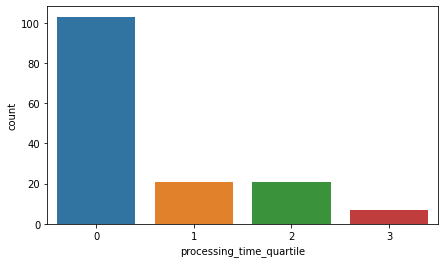

In [4]:
# TO-DO extend to all cases (or a subset of most relevant)

#activity_name = activities_srt_by_duration_std.head(1).index[0]
case_type = 2

case_df = by_case_type.get_group(case_type).drop(columns=["k_proto_cluster"])

case_df['processing_time_quartile'] = pd.cut(case_df['processing_time_sum'], bins=4, 
                                     labels=list(range(0,4)))

#cat_cols.append('duration_quartile')

categorical_indexes = [case_df.columns.get_loc(f"{c}") for c in cat_cols]
num_cols = case_df.columns[list(set(list(range(0, len(case_df.columns))))-set(categorical_indexes))]

display(f"Analized case type: {case_type}")
display(case_df[['processing_time_sum', 'waiting_time_sum']].describe())

plt.subplots(figsize = (7, 4))
sns.countplot(x='processing_time_quartile', data = case_df)
plt.show()    

Cost: 151.97195531569005


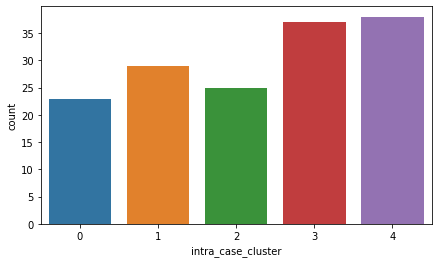

In [5]:
clusters, centers  = clust_kproto(case_df, categorical_indexes, num_cols, K_MODES_ELBOW=5) # elbow value 0 to force best k re-computation

case_df['intra_case_cluster'] = clusters
case_df.to_pickle(OUTPUT_DF_NAME)

plt.subplots(figsize = (7, 4))
sns.countplot(x='intra_case_cluster', data = case_df)
plt.show()

#### Explainability: Intra-case clusters


Grouping by intra_case_cluster

7 Decision Rules found:

if (end_wip_mean > 310.679) and (end_wip_mean <= 332.136) and (rp_st_oc_sum > 0.047) then class = 4 | Prob: 40.0%, based on 30 samples
if (end_wip_mean <= 310.679) and (st_tsk_wip_sum <= 4.5) and (end_daytime > 18143.5) then class = 1 | Prob: 100.0%, based on 30 samples
if (end_wip_mean > 310.679) and (end_wip_mean > 332.136) then class = 4 | Prob: 100.0%, based on 25 samples
if (end_wip_mean <= 310.679) and (st_tsk_wip_sum <= 4.5) and (end_daytime <= 18143.5) then class = 2 | Prob: 79.17%, based on 24 samples
if (end_wip_mean <= 310.679) and (st_tsk_wip_sum > 4.5) and (rp_st_oc_mean <= 0.045) then class = 3 | Prob: 57.14%, based on 21 samples
if (end_wip_mean <= 310.679) and (st_tsk_wip_sum > 4.5) and (rp_st_oc_mean > 0.045) then class = 0 | Prob: 80.0%, based on 15 samples
if (end_wip_mean > 310.679) and (end_wip_mean <= 332.136) and (rp_st_oc_sum <= 0.047) then class = 2 | Prob: 85.71%, based on 7 samples


processing_time_sum                                    \
                                 count     mean     std     min      25%   
intra_case_cluster                                                         
0                                23.00 18334.61 7138.06 4148.00 16351.00   
1                                29.00  4160.69 6139.51    0.00     0.00   
2                                25.00  9180.08 5396.76  821.00  6420.00   
3                                37.00  3253.05 2946.29    0.00   480.00   
4                                38.00  5787.71 6249.70    0.00   726.00   

                                              waiting_time_sum                 \
                        50%      75%      max            count   mean     std   
intra_case_cluster                                                              
0                  18300.00 23877.00 31946.00            23.00 636.52 1418.45   
1                   1920.00  5015.00 22458.00            29.00   0.00    0.00   
2                   7941.00  9840.00 24286.00            25.00   0.00    0.00   
3                   2648.00  6181.00  8757.00            37.00   0.00    0.00   
4                   3055.50  8158.25 18992.00            38.00   0.00    0.00   

                                                
                    min  25%  50%  75%     max  
intra_case_cluster                              
0                  0.00 0.00 0.00 0.00 3660.00  
1                  0.00 0.00 0.00 0.00    0.00  
2                  0.00 0.00 0.00 0.00    0.00  
3                  0.00 0.00 0.00 0.00    0.00  
4                  0.00 0.00 0.00 0.00    0.00

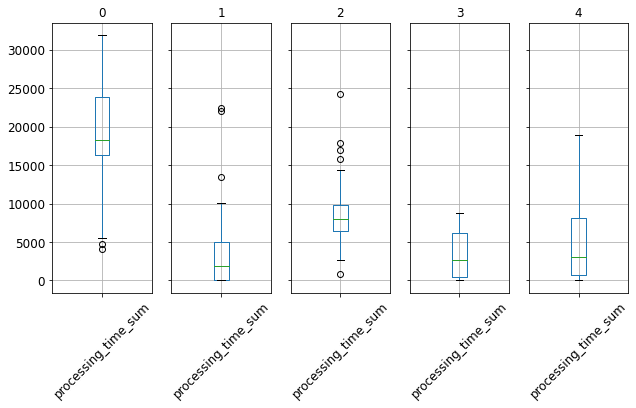

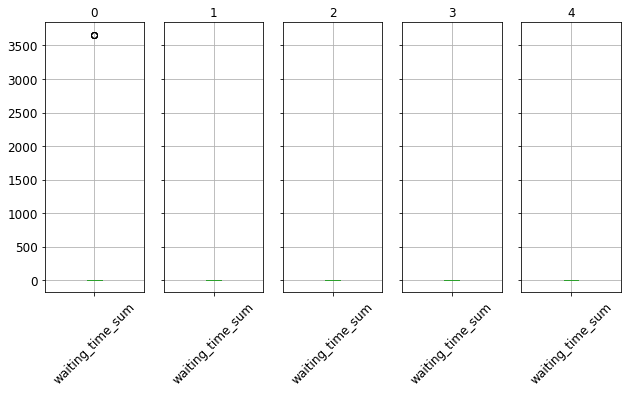

In [6]:
# One-hot encoding necessary because sk-learn dec. tree classifier does not handle categorical vars.
for c in cat_cols:
    case_df[c] = case_df[c].apply(str)
one_hot_data = pd.get_dummies(case_df[cat_cols],drop_first=True)
enc_case_df = pd.merge(case_df.drop(columns=cat_cols), one_hot_data, left_index=True, right_index=True)

clf, rule_printer, path_visualizer, top_feature_getter, duration_stats_getter = explainer_sklearn_dt(enc_case_df, "intra_case_cluster", exclude=["processing_time_quartile", "processing_time_sum", "waiting_time_sum"], max_depth=3, min_samples_leaf=1, min_samples_split=0.1, criterion="entropy")

rule_printer()

stats = duration_stats_getter(_figsize=(10, 5))
stats.describe()

##### Visualizing decision path of particular cases

In [7]:
cases = []
for cluster in np.unique(enc_case_df.intra_case_cluster):
    case = enc_case_df[enc_case_df.intra_case_cluster == cluster].sample().iloc[0]
    cases.append(case)
    path_visualizer(case)

# To print the particular cases in a table, displaying the most important features of the decision tree + labels by different methods
pd.DataFrame(cases)[top_feature_getter(5)+['intra_case_cluster']]



Case class: 0.0
Reasons:
18143.5 <= end_daytime 
st_tsk_wip_sum < 4.5
end_wip_mean < 310.68


Case class: 1.0
Reasons:
end_daytime < 18143.5
st_tsk_wip_sum < 4.5
end_wip_mean < 310.68


Case class: 2.0
Reasons:
4.5 <= st_tsk_wip_sum 
0.04 <= rp_st_oc_mean 
end_wip_mean < 310.68


Case class: 3.0
Reasons:
end_daytime < 18143.5
st_tsk_wip_sum < 4.5
end_wip_mean < 310.68


Case class: 4.0
Reasons:
end_daytime < 18143.5
st_tsk_wip_sum < 4.5
end_wip_mean < 310.68



,end_wip_mean,st_tsk_wip_sum,end_daytime,rp_st_oc_sum,rp_st_oc_mean,intra_case_cluster
112802,327.14,10.00,60846.00,0.36,0.05,0.00
110603,297.67,1.00,8332.00,0.00,0.00,1.00
106702,303.67,9.00,82144.00,0.16,0.03,2.00
116927,290.50,6.00,83741.00,0.10,0.03,3.00
116267,326.50,6.00,80637.00,0.14,0.04,4.00


### Explainability: Processing Time quartiles

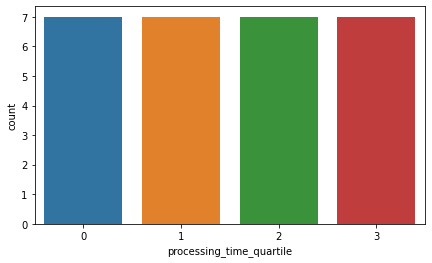


Grouping by processing_time_quartile

8 Decision Rules found:

if (st_tsk_wip_sum <= 6.5) and (st_month_5 <= 0.5) and (st_wip_max <= 325.0) and (st_wip_sum <= 2263.0) then class = 0 | Prob: 85.71%, based on 7 samples
if (st_tsk_wip_sum > 6.5) and (rp_end_oc_mean <= 0.021) then class = 3 | Prob: 100.0%, based on 6 samples
if (st_tsk_wip_sum <= 6.5) and (st_month_5 <= 0.5) and (st_wip_max > 325.0) then class = 2 | Prob: 100.0%, based on 5 samples
if (st_tsk_wip_sum <= 6.5) and (st_month_5 > 0.5) and (st_wip_max <= 343.0) then class = 1 | Prob: 100.0%, based on 4 samples
if (st_tsk_wip_sum > 6.5) and (rp_end_oc_mean > 0.021) and (st_weekday_2 > 0.5) then class = 2 | Prob: 50.0%, based on 2 samples
if (st_tsk_wip_sum > 6.5) and (rp_end_oc_mean > 0.021) and (st_weekday_2 <= 0.5) then class = 1 | Prob: 100.0%, based on 2 samples
if (st_tsk_wip_sum <= 6.5) and (st_month_5 > 0.5) and (st_wip_max > 343.0) then class = 0 | Prob: 100.0%, based on 1 samples
if (st_tsk_wip_sum <= 6.5) and (st_mont

processing_time_sum                            \
                                       count     mean     std      min   
processing_time_quartile                                                 
0                                       7.00  1989.43 2826.42     0.00   
1                                       7.00 10376.86 2608.10  8246.00   
2                                       7.00 19871.14 2458.36 16973.00   
3                                       7.00 26140.57 2729.43 24286.00   

                                                             waiting_time_sum  \
                              25%      50%      75%      max            count   
processing_time_quartile                                                        
0                          334.00   493.00  2435.00  7895.00             7.00   
1                         8698.50  9996.00 10578.50 15842.00             7.00   
2                        18030.00 18956.00 21979.50 23150.00             7.00   
3                        24661.50 25012.00 26208.50 31946.00             7.00   

                                                                     
                           mean     std  min  25%  50%  75%     max  
processing_time_quartile                                             
0                          0.00    0.00 0.00 0.00 0.00 0.00    0.00  
1                          0.00    0.00 0.00 0.00 0.00 0.00    0.00  
2                          0.00    0.00 0.00 0.00 0.00 0.00    0.00  
3                        522.86 1383.35 0.00 0.00 0.00 0.00 3660.00

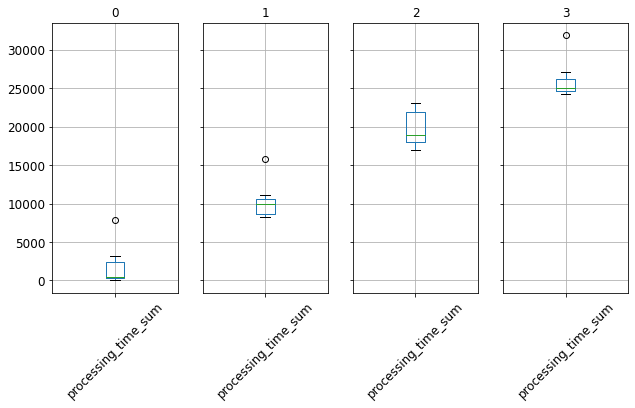

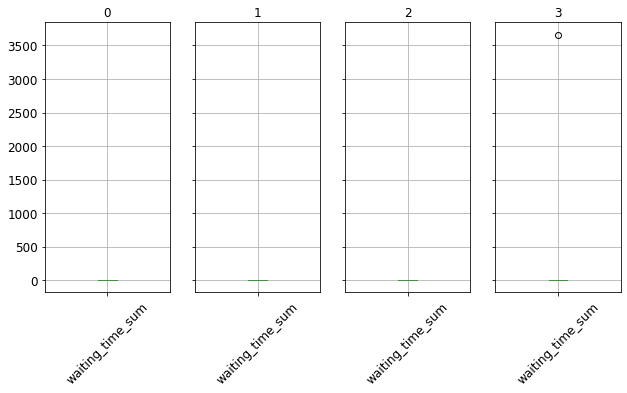

In [8]:
# One-hot encoding necessary because sk-learn dec. tree classifier does not handle categorical vars.
for c in cat_cols:
    case_df[c] = case_df[c].apply(str)
one_hot_data = pd.get_dummies(case_df[cat_cols],drop_first=True)
enc_case_df = pd.merge(case_df.drop(columns=cat_cols), one_hot_data, left_index=True, right_index=True)

enc_case_df = enc_case_df.groupby('processing_time_quartile')
enc_case_df = pd.DataFrame(enc_case_df.apply(lambda x: x.sample(enc_case_df.size().min()).reset_index(drop=True)))
enc_case_df = enc_case_df.reset_index(drop=True)

plt.subplots(figsize = (7, 4))
sns.countplot(x='processing_time_quartile', data = enc_case_df)
plt.show()  

clf, rule_printer, path_visualizer, top_feature_getter, duration_stats_getter = explainer_sklearn_dt(enc_case_df, "processing_time_quartile", exclude=["intra_case_cluster", "processing_time_sum", "waiting_time_sum"], max_depth=4, min_samples_leaf=1, min_samples_split=0.1, criterion="entropy")

rule_printer()

stats = duration_stats_getter(_figsize=(10, 5))
stats.describe()

In [9]:
cases = []
for processing_time_quartile in np.unique(enc_case_df.processing_time_quartile):
    case = enc_case_df[enc_case_df.processing_time_quartile == processing_time_quartile].sample().iloc[0]
    cases.append(case)
    path_visualizer(case)

# To print the particular cases in a table, displaying the most important features of the decision tree + labels by different methods
pd.DataFrame(cases)[top_feature_getter(5)+['processing_time_quartile']]


Case class: 0.0
Reasons:
325.0 <= st_wip_max 
st_tsk_wip_sum < 6.5
st_month_5 < 0.5


Case class: 1.0
Reasons:
325.0 <= st_wip_max 
st_tsk_wip_sum < 6.5
st_month_5 < 0.5


Case class: 2.0
Reasons:
343.0 <= st_wip_max 
st_tsk_wip_sum < 6.5
0.5 <= st_month_5 


Case class: 3.0
Reasons:
325.0 <= st_wip_max 
st_tsk_wip_sum < 6.5
st_month_5 < 0.5



,st_tsk_wip_sum,st_wip_max,st_month_5,rp_end_oc_mean,st_wip_sum,processing_time_quartile
3,6.00,316.00,0.00,0.02,2176.00,0.00
13,8.00,350.00,0.00,0.05,3630.00,1.00
14,3.00,360.00,0.00,0.00,1428.00,2.00
23,12.00,316.00,0.00,0.01,2296.00,3.00
